# Hand Tracking with Tensorflow Lite

Automatic detection hands from plain RGB images is an underated and deceptibly complex task. The algorithm of choice, whichever it may be, should able to coup with issues like:

1. Various hand sizes with a huge scale variation relative to the image background
2. Occluded and self-occluded hands.
3. Lack of features (e.g. faces show high contrast patterns in eye, mouth and other regions) in hands increases the difficult to detect them reliably from their visual features alone. 

Some approaches rely on a clear contrast between the hand and the background and apply more traditional filtering techniques to focus in the hand (see [this implementation](https://dev.to/amarlearning/finger-detection-and-tracking-using-opencv-and-python-586m) for example). Others suggest providing additional context, like arm, body, or body features to aid the hand detection process, with some degree of success.

However, recently Google-AI research made [news](https://techcrunch.com/2019/08/19/this-hand-tracking-algorithm-could-lead-to-sign-language-recognition/?guccounter=1&guce_referrer=aHR0cHM6Ly9kdWNrZHVja2dvLmNvbS8&guce_referrer_sig=AQAAAAFfuUixBF3rPQtyVpmfUpTDhQJccb7LVcDbuQWWNBXyU-FRqffyB_VaSsSWPQdYrqN5eheIWB1HVGjrgkGWMMOLtSqxcGjzF80c3A3EdVM0cJf_DlULGNMx_gUVz80WK8KBmrsQOeFjpJv25GbP58XBPWIkXj1HNE9I9T6K8St-) when it presented a new approach at [CVPR 2019](http://cvpr2019.thecvf.com/). The aim of the research was to allow sing-language reading. This new approach suggest first to train a "palm detector" instead of a "hand detector", since estimating bounding boxes of rigid objects like palms and fists is significantly simpler than detecting hands with articulated fingers. Then, an encoder-decoder feature extractor is used for scene-context-awareness. And lastly, it minimizes the focal loss during training to support a large amount of anchors resulting from the high scale variance (more details on the [researcher's blog](https://ai.googleblog.com/2019/08/on-device-real-time-hand-tracking-with.html)). 

The approach is not only novel from the design perspective but also from the Data Science side, as it leverages both real and synthetic data to train the "palm detector" (which is in essence a [Single Shot Detector](https://arxiv.org/pdf/1512.02325.pdf), contender of the renown [YOLO](https://arxiv.org/pdf/1506.02640.pdf); see the figure below). To make matters even more interesting, the full implementation and the pre-trained models were open-sourced as part of Google's mixed-OS framework for mobile app development, [MediaPipe](https://github.com/google/mediapipe). Further more, models are pre-converted to `.tflite` format, the high-performance static graph format used by [Tensorflow Lite](https://www.tensorflow.org/lite/) to execute  real-time inference on mobile/edge device! The development community couldn't be more happy.


<img src="../media/dnn_archi.png" width="500" >

## Hands on the tech
Although it migh be bit downgrading to run such process on python, as opposed to its intend low level runtime environment, for educational purposes let us dissect the [original project](https://github.com/google/mediapipe/blob/master/mediapipe/docs/hand_tracking_mobile_gpu.md) and look into how to load the model, feed it data and evaluate its results using a `jupyter notebook`. For now we will focus only on the "palm detector" and leave the posture recognition for later.

If you haven't installed the required python libraries into your virtual environment yet, you may do so now by running the cell bellow:

In [ ]:
%%bash
pip install -r ../requirements.txt

In [2]:
import os
import time
import csv
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf

Having imported all the required libraries, let us load the labels (only 1 in this case since there is only one class), [anchor boxes](https://www.coursera.org/lecture/convolutional-neural-networks/anchor-boxes-yNwO0) definitions and the model itself into memory.

**NOTE**:  The "palm detector" graph available in the MediaPipe [repo](https://github.com/google/mediapipe/tree/master/mediapipe/models) detector uses some custom operations that are not included in the standard distribution of `Tensorflow`. Special thanks to [@metalwhale](https://github.com/metalwhale) for porting the model (using the procedure discribed by the developers) and sharing it so we can speed up this tutorial.

<img src="../media/issue_solution.png" width="600" >

In [3]:
labels_path = "../tflite_model/palm_detection_labelmap.txt"
with open(labels_path, "r") as f:
    labels = [line.strip() for line in f.readlines()]

In [4]:
labels

['Palm']

In [5]:
anchors_path = "../tflite_model/palm_detection_anchors.csv"
with open(anchors_path, "r") as csv_f:
    anchors_list = [x for x in csv.reader(csv_f, quoting=csv.QUOTE_NONNUMERIC)]
    anchors = np.vstack(anchors_list)

In [6]:
model_path = "../tflite_model/palm_detection.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

Now that the graph is in memory, a helpfull step is to check the shape and type of its input/ouput tensors (e.g. its signature)

In [7]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_height = input_details[0]["shape"][1]
input_width = input_details[0]["shape"][2]

In [8]:
input_details

[{'name': 'input_1',
  'index': 234,
  'shape': array([  1, 256, 256,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [9]:
output_details

[{'name': 'regressors/concat',
  'index': 295,
  'shape': array([   1, 2944,   18], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)},
 {'name': 'classificators/concat',
  'index': 14,
  'shape': array([   1, 2944,    1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

As you can see, the model is expecting a `1x256x256x3` input tensor; that is a scared RGB image 256px wide. As a side note,  we will see that the model we are working with uses floating point tensors. `Tensorflow Lite` supports quantized graphs as well (interger precision) for cases where graph computation resources should kept to a minimal (you can learn more from [this talk](https://www.youtube.com/watch?v=Jjm7MT6W0Dc&list=PLOU2XLYxmsILVTiOlMJdo7RQS55jYhsMi&index=21&t=0s)).

With regards to the outputs, we have:
* The bounding box regression: the centroid of the anchors for the detections (`cx`,`cy`), the (`dx,dy`) deviation of the boxes centers from the achor's centroids and width `w` and height `h` of the boxes.
* The classification score: a value that states the confidence that a given detection actually corresponds to our single class.

We are now ready to load a test image, preprocess it (pad, resize and normalize) to match the expected input form, and to perform the the inference.

In [10]:
image_path = "../media/hand.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

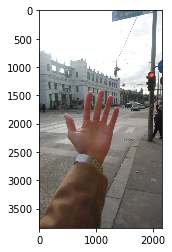

In [11]:
_ = plt.imshow(image_rgb)

In [12]:
shape = np.hstack(image_rgb.shape)
pad = (shape.max() - shape[:2]).astype('uint32') // 2
padded_image = np.pad(image_rgb, ((pad[0],pad[0]), (pad[1],pad[1]), (0,0)), mode='constant')
resized_image = cv2.resize(padded_image, (256, 256))
normalized_image = np.ascontiguousarray(2 * ((resized_image / 255) - 0.5 ).astype('float32'))

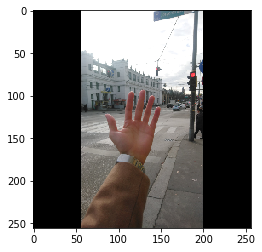

In [13]:
_ = plt.imshow(resized_image)

In [14]:
interpreter.set_tensor(input_details[0]['index'], normalized_image[None])
interpreter.invoke()

In [15]:
bboxes = interpreter.get_tensor(output_details[0]['index'])[0]
scores = interpreter.get_tensor(output_details[1]['index'])[0,:,0]

The outputs we just obtained need some post-processing before we can plot it all.

First, finding the best prediction is usually done though [Non-max Supression](https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/) algorithm. This is basically to ensure anchor boxes of similar shape are not being applied to two neighboring centroids; that is, avoid having to boxes overlapping on the same detected object.

To keep thing simple though, here we will simple convert the scores to values that are easier to compare. The conversion we use is a simple [Sigmoid activation](https://en.wikipedia.org/wiki/Sigmoid_function). Then we filter out the ones that are below some confidence value (we arbitrary select 0.7) and finally we take the highest of them all as our final detection.

Once we have single candidate, the remining work is some arithmetic to make the bounding box fit the original image, instead of the padded downsized version the model got as an input.

In [16]:
min_confidence = 0.7
canditate_indices = (1 / (1 + np.exp(-scores) ) ) > min_confidence
candidate_detections = bboxes[canditate_indices]
candidate_anchors = anchors[canditate_indices]

/home/yo/venv/py3_7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [17]:
if candidate_detections.shape[0] == 0:
    print("Failed to produce detection with the desired confidence")
else:
    print("Successfully produced {} detections ".format(candidate_detections.shape[0]))    

Succesfully produced 5 detections 


In [18]:
best_candidate_index = np.argmax(candidate_detections[:, 3])

dx,dy,w,h = candidate_detections[best_candidate_index, :4]
centroid = candidate_anchors[best_candidate_index,:2] * 256

enlarge_factor = 2
resize_scale = max(shape)/256

cx, cy = tuple(centroid.astype(int))
ncx, ncy = int(cx+dx), int(cy+dy)

nw = w*enlarge_factor
nh = h*enlarge_factor

xmin = int(resize_scale*(ncx - nw/2))
ymin = int(resize_scale*(ncy - nh/2))
xmax = int(resize_scale*(ncx + nw/2))
ymax = int(resize_scale*(ncy + nh/2))

if shape[0] > shape[1]:
    xmin = xmin - pad[1]
    xmax = xmax - pad[1]
else:
    ymin = ymin - pad[1]
    ymax = ymax - pad[1]

Now we choose a fruity color and overlay the box on the input RGB image. Optionally, we add a label with some text. Note that here we are not stating the actual confidence of the detection, just that is above the user-specified threshold. This is due to the limitations mentioned above about the missing Non-max Supression implementation.

In [19]:
color_rgb = (128,255,170)
_ = cv2.rectangle(image_rgb, (xmin, ymin), (xmax, ymax), color_rgb, thickness=25)

In [20]:
label = "{} - conf. {}% or above".format(labels[0], min_confidence*100)
label_size, base_line = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
label_ymin = max(ymin, label_size[1] + 10) # Make sure not to draw label too close to top of window
_ = cv2.rectangle(image_rgb, 
                  (xmin, label_ymin-label_size[1]-10), 
                  (xmin+label_size[0], label_ymin+base_line-10), 
                   color_rgb, cv2.FILLED) # Draw white box to put label text in
color_rgb = (0, 0, 0)
_ = cv2.putText(image_rgb, 
                label, 
                (xmin, label_ymin-7), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, color_rgb, 2) # Draw label text

Finally, let us save the plot to an image file:

In [21]:
_ = cv2.imwrite("../media/detected_hand.jpg", image_rgb[:, :, [2, 1, 0]])

And there you have it. Is worth pointing out that the model was also trained to detect forehands, fists and partially occluded hands (see some imsges below). Naturally, the algorithm can be used to process video stream. It will be definatively interesting to bechmark the performance of a python application runnig on video to see if we can achive real-time processing. Some scripts to perform such benchmarks will be shared in the near future. Hope you found all this helpful :)

<img src="../media/detected_hand.jpg" width="500" height="280">

<img src="../media/detected_backhand.jpg" width="500" height="280">

<img src="../media/detected_occluded_hand.jpg" width="500" height="280">